In [1]:
import pretty_midi
import os
from collections import defaultdict
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
from miditok.pytorch_data import DatasetMIDI, DataCollator
import datetime
from collections import Counter
from sklearn.model_selection import train_test_split

/Users/leofriedman/Desktop/ucsd/cse_253/cse153-group-project/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_progress_bar(iteration, total, prefix='', length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% Complete', end='\r', flush=True)
    if iteration == total:
        print()

In [3]:
def valid_midi_files(filepaths):
    valid_files = []
    for i, filepath in enumerate(filepaths):
        try:
            midi_data = pretty_midi.PrettyMIDI(filepath)
            if len(midi_data.instruments) > 0:
                valid_files.append(filepath)
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
        print_progress_bar(i+1, len(filepaths), prefix='Validating MIDI files')
    return valid_files

In [48]:
midi_dirpath = 'nesmdb_midi/'
midi_train_dirpath = os.path.join(midi_dirpath, 'train')
midi_test_dirpath = os.path.join(midi_dirpath, 'test')
midi_val_dirpath = os.path.join(midi_dirpath, 'valid')
midi_train_filesnames = os.listdir(midi_train_dirpath)
midi_test_filesnames = os.listdir(midi_test_dirpath)
midi_val_filenames = os.listdir(midi_val_dirpath)

midi_train_filepaths = valid_midi_files([os.path.join(midi_train_dirpath, filename) for filename in midi_train_filesnames])
midi_test_filepaths = valid_midi_files([os.path.join(midi_test_dirpath, filename) for filename in midi_test_filesnames])
midi_val_filepaths = valid_midi_files([os.path.join(midi_val_dirpath, filename) for filename in midi_val_filenames])
all_filepaths = midi_train_filepaths + midi_test_filepaths + midi_val_filepaths

Error processing nesmdb_midi/train/122_FireEmblem_AnkokuRyutoHikarinoTsurugi_30_31EndingOmnibus.mid: MIDI file has a largest tick of 13007350, it is likely corrupt
Error processing nesmdb_midi/train/215_Magician_15_16EpiloguePart1.mid: MIDI file has a largest tick of 24797107, it is likely corrupt
Error processing nesmdb_midi/train/298_SolarJetman_HuntfortheGoldenWarpship_18_19LemonteGameplay.mid: MIDI file has a largest tick of 12682092, it is likely corrupt
Error processing nesmdb_midi/train/122_FireEmblem_AnkokuRyutoHikarinoTsurugi_28_29EndingOmnibusBallad.mid: MIDI file has a largest tick of 17014635, it is likely corrupt
Error processing nesmdb_midi/train/215_Magician_08_09MountVunarCavernsAbadonsCastle.mid: MIDI file has a largest tick of 16907305, it is likely corrupt
Error processing nesmdb_midi/train/405_ZombieNation_03_04VergeofDangerRoundSelect.mid: MIDI file has a largest tick of 18033915, it is likely corrupt
Error processing nesmdb_midi/train/104_FamicomJumpII_Saikyono7_n

In [5]:
TIME_SHIFT_RESOLUTION = 0.01  # 50 ms
MAX_SHIFT_STEPS = 100  # Max 5 seconds
BEGINNING_OF_SONG_TOKEN = '<BOS>'
END_OF_SONG_TOKEN = '<EOS>'
PAD_TOKEN = '<PAD>'
VOCABULARY = dict()
index = 0

for special_token in [PAD_TOKEN, BEGINNING_OF_SONG_TOKEN, END_OF_SONG_TOKEN]:
    VOCABULARY[special_token] = index
    index += 1

for time_shift in range(1, MAX_SHIFT_STEPS + 1):
    VOCABULARY[f'time_shift_{time_shift}'] = index
    index += 1

for action in ["note_on", "note_off"]:
    for pitch in range(128):
        for program in [80, 81, 38, 121]:
            VOCABULARY[f'{action}_{pitch}_instrument_{program}'] = index
            index += 1

print(f'Vocabulary size: {len(VOCABULARY)}')
print(f'Vocabulary: {VOCABULARY}')

Vocabulary size: 1127
Vocabulary: {'<PAD>': 0, '<BOS>': 1, '<EOS>': 2, 'time_shift_1': 3, 'time_shift_2': 4, 'time_shift_3': 5, 'time_shift_4': 6, 'time_shift_5': 7, 'time_shift_6': 8, 'time_shift_7': 9, 'time_shift_8': 10, 'time_shift_9': 11, 'time_shift_10': 12, 'time_shift_11': 13, 'time_shift_12': 14, 'time_shift_13': 15, 'time_shift_14': 16, 'time_shift_15': 17, 'time_shift_16': 18, 'time_shift_17': 19, 'time_shift_18': 20, 'time_shift_19': 21, 'time_shift_20': 22, 'time_shift_21': 23, 'time_shift_22': 24, 'time_shift_23': 25, 'time_shift_24': 26, 'time_shift_25': 27, 'time_shift_26': 28, 'time_shift_27': 29, 'time_shift_28': 30, 'time_shift_29': 31, 'time_shift_30': 32, 'time_shift_31': 33, 'time_shift_32': 34, 'time_shift_33': 35, 'time_shift_34': 36, 'time_shift_35': 37, 'time_shift_36': 38, 'time_shift_37': 39, 'time_shift_38': 40, 'time_shift_39': 41, 'time_shift_40': 42, 'time_shift_41': 43, 'time_shift_42': 44, 'time_shift_43': 45, 'time_shift_44': 46, 'time_shift_45': 47, 

In [6]:
ID_TO_TOKEN = {v: k for k, v in VOCABULARY.items()}

In [82]:
def midi_to_tokens(pm: pretty_midi.PrettyMIDI):
    events = []

    for instrument in pm.instruments:
        for note in instrument.notes:
            events.append((note.start, f'note_on_{note.pitch}_instrument_{instrument.program}'))
            events.append((note.end, f'note_off_{note.pitch}_instrument_{instrument.program}'))
    
    events.sort()  # Sort by time

    tokens = []
    last_time = 0.0
    for time, event in events:
        delta = time - last_time
        steps = round(delta / TIME_SHIFT_RESOLUTION)

        while steps > 0:
            shift = min(steps, MAX_SHIFT_STEPS)
            tokens.append(f'time_shift_{shift}')
            steps -= shift
        
        tokens.append(event)
        last_time = time
    return [BEGINNING_OF_SONG_TOKEN] + tokens + [END_OF_SONG_TOKEN]

def tokens_to_midi(tokens):
    pm = pretty_midi.PrettyMIDI()
    instruments = dict()
    active_notes = dict()

    current_time = 0.0
    for token in tokens:
        if token.startswith('time_shift_'):
            shift_steps = int(token.split('_')[-1])
            current_time += shift_steps * TIME_SHIFT_RESOLUTION
        elif token.startswith('note_on_'):
            pitch = int(token.split('_')[2])
            instrument = int(token.split('_')[-1])
            active_notes[(pitch, instrument)] = current_time
        elif token.startswith('note_off_'):
            pitch = int(token.split('_')[2])
            instrument = int(token.split('_')[-1])
            if (pitch, instrument) not in active_notes:
                print(f"Warning: Note off for {pitch} on instrument {instrument} without matching note on.")
                continue
            start_time = active_notes[(pitch, instrument)]

            if instrument not in instruments:
                instruments[instrument] = pretty_midi.Instrument(program=instrument)

            note = pretty_midi.Note(
                velocity=100, pitch=pitch, start=start_time, end=current_time
            )

            instruments[instrument].notes.append(note)
            
    for instrument in instruments.values():
        pm.instruments.append(instrument)
    
    return pm

In [15]:
midi = pretty_midi.PrettyMIDI(all_filepaths[0])
tokens = midi_to_tokens(midi)
print(tokens[:30])
midi_reconstructed = tokens_to_midi(tokens)
# midi_reconstructed.write('reconstructed_midi.mid')
# midi.write('original_midi.mid')

['<BOS>', 'note_on_70_instrument_81', 'note_on_62_instrument_80', 'note_on_58_instrument_38', 'time_shift_37', 'note_off_58_instrument_38', 'time_shift_1', 'note_off_70_instrument_81', 'note_off_62_instrument_80', 'time_shift_2', 'note_on_70_instrument_81', 'note_on_62_instrument_80', 'note_on_58_instrument_38', 'time_shift_7', 'note_off_58_instrument_38', 'time_shift_1', 'note_off_70_instrument_81', 'note_off_62_instrument_80', 'time_shift_2', 'note_on_70_instrument_81', 'note_on_62_instrument_80', 'note_on_58_instrument_38', 'time_shift_7', 'note_off_58_instrument_38', 'time_shift_1', 'note_off_70_instrument_81', 'note_off_62_instrument_80', 'time_shift_2', 'note_on_70_instrument_81', 'note_on_62_instrument_80']


In [7]:
def load_sequences(filepaths):
    sequences = []
    for i, filepath in enumerate(filepaths):
        pm = pretty_midi.PrettyMIDI(filepath)
        tokens = midi_to_tokens(pm)
        if not tokens:
            raise ValueError(f'No tokens generated for {filepath}')
        sequences.append([VOCABULARY[token] for token in tokens])
        print_progress_bar(i+1, len(filepaths), prefix='Loading sequences')
    return sequences

class MIDITokenDataset(Dataset):
    def __init__(self, sequences, seq_length=512):
        self.inputs = []
        self.targets = []
        for ind, seq in enumerate(sequences):
            num_chunks = len(seq) // (seq_length + 1)
            for chunk in range(num_chunks + 1):
                chunk_start = chunk * (seq_length + 1)
                chunk_end = chunk_start + seq_length + 1
                chunk = seq[chunk_start:chunk_end]

                if len(chunk) < seq_length / 4:
                    continue

                input = chunk[:-1]
                input = np.pad(input, (0, seq_length - len(input)), constant_values=VOCABULARY[PAD_TOKEN])
                
                target = chunk[1:]
                target = np.pad(target, (0, seq_length - len(target)), constant_values=VOCABULARY[PAD_TOKEN])
                
                self.inputs.append(torch.tensor(input, dtype=torch.long))
                self.targets.append(torch.tensor(target, dtype=torch.long))
            
            print_progress_bar(ind+1, len(sequences), prefix='Processing sequences')

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [61]:
# Load and convert
train_sequences = load_sequences(midi_train_filepaths)
val_sequences = load_sequences(midi_val_filepaths)

Loading sequences |██████████████████████████████████████████████████| 100.0% Complete
Loading sequences |██████████████████████████████████████████████████| 100.0% Complete


In [62]:

def print_sequence_percentiles(sequences, prefix=''):
    print(f'{prefix} sequences: {len(sequences)}')
    print(f"{prefix} 90th percile length: {np.percentile([len(seq) for seq in sequences], 90)}")
    print(f"{prefix} 50th percile length: {np.percentile([len(seq) for seq in sequences], 50)}")
    print(f"{prefix} 25th percile length: {np.percentile([len(seq) for seq in sequences], 25)}")
    print(f"{prefix} 10th percile length: {np.percentile([len(seq) for seq in sequences], 10)}")
    print(f"{prefix} max train sequence length: {max(len(seq) for seq in sequences)}")
    print(f"{prefix} min train sequence length: {min(len(seq) for seq in sequences)}")

print_sequence_percentiles(train_sequences, prefix='Train')
print_sequence_percentiles(val_sequences, prefix='Validation')

Train sequences: 4470
Train 90th percile length: 4361.699999999999
Train 50th percile length: 944.0
Train 25th percile length: 286.25
Train 10th percile length: 99.0
Train max train sequence length: 27506
Train min train sequence length: 7
Validation sequences: 402
Validation 90th percile length: 4329.300000000001
Validation 50th percile length: 682.0
Validation 25th percile length: 176.0
Validation 10th percile length: 73.0
Validation max train sequence length: 14466
Validation min train sequence length: 14


In [78]:
# Create datasets
train_dataset = MIDITokenDataset(train_sequences[:4], seq_length=512)
val_dataset = MIDITokenDataset(val_sequences[:1], seq_length=512)
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Processing sequences |██████████████████████████████████████████████████| 100.0% Complete
Processing sequences |██████████████████████████████████████████████████| 100.0% Complete
Train dataset size: 7
Validation dataset size: 5


In [28]:
class MusicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(MusicRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        out, hidden = self.rnn(x, hidden)  # out: (batch_size, seq_length, hidden_dim)
        out = self.fc(out)  # (batch_size, seq_length, vocab_size)
        return out, hidden

In [ ]:
def train(model, train_loader, val_loader, vocab_size, num_epochs=20, lr=0.001, device='cuda'):
    time_start = time.time()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # --------- Training ---------
        model.train()
        total_train_loss = 0

        for i, batch in enumerate(train_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)

            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            print_progress_bar(i+1, len(train_loader), prefix='Training...')

        avg_train_loss = total_train_loss / len(train_loader)

        # --------- Validation ---------
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs, _ = model(inputs)
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

                print_progress_bar(i+1, len(val_loader), prefix='Validating...')

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [ ]:
batch_size = 8  # You can adjust this depending on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MusicRNN(vocab_size=len(VOCABULARY), embedding_dim=256, hidden_dim=256, num_layers=2)
train(model, train_loader, val_loader, vocab_size=len(VOCABULARY), device=device)

Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 1/20 | Train Loss: 7.0312 | Val Loss: 6.8262
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 2/20 | Train Loss: 6.8262 | Val Loss: 6.4490
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 3/20 | Train Loss: 6.4490 | Val Loss: 6.0285
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 4/20 | Train Loss: 6.0285 | Val Loss: 5.7496
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |████████████████████████████████████████████

In [40]:
def sample(model, start_token, max_length=100, temperature=1.0, device='cuda'):
    model = model.to(device)
    model.eval()

    generated = [start_token]
    input_token = torch.tensor([[start_token]], device=device)  # (1, 1)

    hidden = None

    for _ in range(max_length):
        output, hidden = model(input_token, hidden)  # output: (1, 1, vocab_size)
        output = output[:, -1, :]  # take the last output
        output = output / temperature  # adjust randomness

        probs = F.softmax(output, dim=-1)  # (1, vocab_size)
        next_token = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_token)
        if next_token == VOCABULARY[END_OF_SONG_TOKEN] or VOCABULARY[PAD_TOKEN]: # reach end of sequence
          break

        input_token = torch.tensor([[next_token]], device=device)

    return generated



In [ ]:
start_token = VOCABULARY[BEGINNING_OF_SONG_TOKEN]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generated_sequence = sample(model, start_token, max_length=1024, device=device)
generated_tokens = [ID_TO_TOKEN[token] for token in generated_sequence]
tokens_reconstructed = tokens_to_midi(generated_tokens)
tokens_reconstructed.write('generated_midi.mid')

### Train Soloists

In [10]:
def valid_soloist_midi_files(filepaths, instrument_program):
    valid_files = []
    for i, filepath in enumerate(filepaths):
        try:
            midi_data = pretty_midi.PrettyMIDI(filepath)
            if len(midi_data.instruments) > 0 and any(instrument.program == instrument_program for instrument in midi_data.instruments):
                valid_files.append(filepath)
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
        print_progress_bar(i+1, len(filepaths), prefix='Validating MIDI files')
    return valid_files

In [8]:
unique_instruments = [80, 81, 38, 121]

In [11]:
soloist_80_midi_train_filepaths = valid_soloist_midi_files(midi_train_filepaths, instrument_program=80)
soloist_81_midi_train_filepaths = valid_soloist_midi_files(midi_train_filepaths, instrument_program=81)
soloist_38_midi_train_filepaths = valid_soloist_midi_files(midi_train_filepaths, instrument_program=38)
soloist_121_midi_train_filepaths = valid_soloist_midi_files(midi_train_filepaths, instrument_program=121)

soloist_80_midi_val_filepaths = valid_soloist_midi_files(midi_val_filepaths, instrument_program=80)
soloist_81_midi_val_filepaths = valid_soloist_midi_files(midi_val_filepaths, instrument_program=81)
soloist_38_midi_val_filepaths = valid_soloist_midi_files(midi_val_filepaths, instrument_program=38)
soloist_121_midi_val_filepaths = valid_soloist_midi_files(midi_val_filepaths, instrument_program=121)

Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete
Validating MIDI files |██████████████████████████████████████████████████| 100.0% Complete


In [22]:
def get_soloist_vocabulary():
    vocabulary = dict()
    index = 0

    for special_token in [PAD_TOKEN, BEGINNING_OF_SONG_TOKEN, END_OF_SONG_TOKEN]:
        vocabulary[special_token] = index
        index += 1

    for time_shift in range(1, MAX_SHIFT_STEPS + 1):
        vocabulary[f'time_shift_{time_shift}'] = index
        index += 1

    for action in ["note_on", "note_off"]:
        for pitch in range(128):
            vocabulary[f'{action}_{pitch}'] = index
            index += 1
    return vocabulary

In [42]:
def get_soloist_id_to_token():
    vocabulary = get_soloist_vocabulary()
    return {v: k for k, v in vocabulary.items()}

In [102]:
def soloist_midi_to_tokens(pm: pretty_midi.PrettyMIDI, instrument_program):
    events = []

    for instrument in pm.instruments:
        if instrument.program == instrument_program:
            for note in instrument.notes:
                events.append((note.start, f'note_on_{note.pitch}'))
                events.append((note.end, f'note_off_{note.pitch}'))
        
            break
        
    
    events.sort()  # Sort by time

    tokens = []
    last_time = 0.0
    for time, event in events:
        delta = time - last_time
        steps = max(round(delta / TIME_SHIFT_RESOLUTION), 1) # force at least 1 step (no side by side notes)

        while steps > 0:
            shift = min(steps, MAX_SHIFT_STEPS)
            tokens.append(f'time_shift_{shift}')
            steps -= shift
        
        tokens.append(event)
        last_time = time
    return [BEGINNING_OF_SONG_TOKEN] + tokens + [END_OF_SONG_TOKEN]

def soloist_tokens_to_midi(tokens, instrument_program):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=instrument_program)

    active_notes = dict()
    active_pitch = None
    active_start = None

    current_time = 0.0
    for token in tokens:
        # print(current_time, token)
        if token.startswith('time_shift_'):
            shift_steps = int(token.split('_')[-1])
            current_time += shift_steps * TIME_SHIFT_RESOLUTION
        elif token.startswith('note_on_'):
            if active_pitch is not None:
                print(f"Warning: Skipping {token}, other note: {active_pitch} is still active.")
                continue 
            pitch = int(token.split('_')[2])
            # active_notes[pitch] = current_time
            active_pitch = pitch
            active_start = current_time
        elif token.startswith('note_off_'):
            pitch = int(token.split('_')[2])
            if pitch != active_pitch:
                print(f"Warning: Note off for {pitch} without matching note on.")
                continue

            if current_time > active_start:
                note = pretty_midi.Note(
                    velocity=100, pitch=pitch, start=active_start, end=current_time
                )

                instrument.notes.append(note)
            else:
                print(f"Warning: Note off for {pitch} at {current_time} note after note on at {active_start}. Ignoring.")
            # del active_notes[pitch]
            active_pitch = None
            active_start = None

    pm.instruments.append(instrument)
    
    return pm

In [19]:
midi = pretty_midi.PrettyMIDI(all_filepaths[0])
tokens_80 = soloist_midi_to_tokens(midi, 80)
tokens_81 = soloist_midi_to_tokens(midi, 81)
tokens_38 = soloist_midi_to_tokens(midi, 38)
tokens_121 = soloist_midi_to_tokens(midi, 121)

midi_reconstructed_80 = soloist_tokens_to_midi(tokens_80, instrument_program=80)
midi_reconstructed_81 = soloist_tokens_to_midi(tokens_81, instrument_program=81)
midi_reconstructed_38 = soloist_tokens_to_midi(tokens_38, instrument_program=38)
midi_reconstructed_121 = soloist_tokens_to_midi(tokens_121, instrument_program=121)

# midi_reconstructed_80.write('reconstructed_midi_80.mid')
# midi_reconstructed_81.write('reconstructed_midi_81.mid')
# midi_reconstructed_38.write('reconstructed_midi_38.mid')
# midi_reconstructed_121.write('reconstructed_midi_121.mid')

# midi.write('original_midi.mid')

In [23]:
def load_soloist_sequences(filepaths, instrument_program):
    vocabulary = get_soloist_vocabulary()
    sequences = []
    for i, filepath in enumerate(filepaths):
        pm = pretty_midi.PrettyMIDI(filepath)
        tokens = soloist_midi_to_tokens(pm, instrument_program)
        if not tokens:
            raise ValueError(f'No tokens generated for {filepath}')
        sequences.append([vocabulary[token] for token in tokens])
        print_progress_bar(i+1, len(filepaths), prefix='Loading sequences')
    return sequences

In [100]:
soloist_80_train_sequences = load_soloist_sequences(soloist_80_midi_train_filepaths, instrument_program=80)
soloist_81_train_sequences = load_soloist_sequences(soloist_81_midi_train_filepaths, instrument_program=81)
soloist_38_train_sequences = load_soloist_sequences(soloist_38_midi_train_filepaths, instrument_program=38)
soloist_121_train_sequences = load_soloist_sequences(soloist_121_midi_train_filepaths, instrument_program=121)

soloist_80_val_sequences = load_soloist_sequences(soloist_80_midi_val_filepaths, instrument_program=80)
soloist_81_val_sequences = load_soloist_sequences(soloist_81_midi_val_filepaths, instrument_program=81)
soloist_38_val_sequences = load_soloist_sequences(soloist_38_midi_val_filepaths, instrument_program=38)
soloist_121_val_sequences = load_soloist_sequences(soloist_121_midi_val_filepaths, instrument_program=121)

Loading sequences |██████████████████████████████████████████████████| 100.0% Complete


KeyboardInterrupt: 

In [ ]:
def get_soloist_model():
    return MusicRNN(vocab_size=len(get_soloist_vocabulary()), embedding_dim=64, hidden_dim=512, num_layers=2)

In [ ]:
def train_soloists(soloist_sequences: dict):
    models = {}
    for instrument_program, (train_sequences, val_sequences) in soloist_sequences.items():
        train_dataset = MIDITokenDataset(train_sequences[:2], seq_length=512)
        val_dataset = MIDITokenDataset(val_sequences[:2], seq_length=512)

        batch_size = 8
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = get_soloist_model()
        train(model, train_loader, val_loader, vocab_size=len(get_soloist_vocabulary()), device=device)
        models[instrument_program] = model
    return models


In [31]:
soloist_sequences = {
    80: (soloist_80_train_sequences, soloist_80_val_sequences),
    81: (soloist_81_train_sequences, soloist_81_val_sequences),
    38: (soloist_38_train_sequences, soloist_38_val_sequences),
    121: (soloist_121_train_sequences, soloist_121_val_sequences)
}
soloist_models = train_soloists(soloist_sequences)

Processing sequences |██████████████████████████████████████████████████| 100.0% Complete
Processing sequences |██████████████████████████████████████████████████| 100.0% Complete
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 1/20 | Train Loss: 5.8776 | Val Loss: 5.7679
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 2/20 | Train Loss: 5.7679 | Val Loss: 5.5858
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 3/20 | Train Loss: 5.5858 | Val Loss: 5.1507
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 4/20 

In [32]:
def save_model_weights(models):
    for instrument_program, model in models.items():
        torch.save(model.state_dict(), f'soloist_model_{instrument_program}.pth')

In [33]:
save_model_weights(soloist_models)

In [51]:
def load_model_weight(path, model):
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

In [113]:
def sample_soloists(models, outdir='./'):
    soloist_vocabulary = get_soloist_vocabulary()
    midis = dict()
    for instrument_program, model in models.items():
        model.eval()  # Set to eval mode for inference
        start_token = soloist_vocabulary[BEGINNING_OF_SONG_TOKEN]
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        generated_sequence = sample(model, start_token, max_length=1024, device=device)
        generated_tokens = [get_soloist_id_to_token()[token] for token in generated_sequence]
        tokens_reconstructed = soloist_tokens_to_midi(generated_tokens, instrument_program=instrument_program)
        midis[instrument_program] = tokens_reconstructed
    
    together_midi = pretty_midi.PrettyMIDI()
    for instrument_program, midi in midis.items():
        together_midi.instruments.extend(midi.instruments)

    os.makedirs(outdir, exist_ok=True)
    outpath = os.path.join(outdir, f'{datetime.datetime.now()}.mid')
    
    together_midi.write(outpath)


In [123]:
# models = [load_model_weight(f'soloist_model_{instrument_program}.pth', get_soloist_model()) for instrument_program in unique_instruments]
model_weights_dir = os.path.join('lstm_models', 'soloists', '2')
# models = {80: load_model_weight(os.path.join(model_weights_dir, 'soloist_model_80.pth'), get_soloist_model())}
models = {instr_program: load_model_weight(os.path.join(model_weights_dir, f'soloist_model_{instr_program}.pth'), get_soloist_model()) for instr_program in unique_instruments}
sample_soloists(models, outdir=os.path.join(model_weights_dir, 'samples'))

In [98]:
side_by_side_note_count = 0
total_tokens = 0
for i, sequence in enumerate(soloist_80_train_sequences):
    pairwise = zip(sequence[:-1], sequence[1:])
    total_tokens += len(sequence)
    for token1, token2 in pairwise:
        token1 = get_soloist_id_to_token()[token1]
        token2 = get_soloist_id_to_token()[token2]
        if token1.startswith('note_on_') and token2.startswith('note_off_'):
            if token1.split('_')[2] == token2.split('_')[2]:
                side_by_side_note_count += 1

    print_progress_bar(i+1, len(soloist_80_train_sequences), prefix='Counting side by side notes')
    
print(f'Side by side note count: {side_by_side_note_count}')
print(f'Total tokens: {total_tokens}')

Counting side by side notes |██████████████████████████████████████████████████| 100.0% Complete
Side by side note count: 121967
Total tokens: 2057224


### Task 2 - Conditional generation

In [33]:
def extract_game_name(filepath):
    filename = os.path.basename(filepath)
    game_name_chunks = filename.split('_')[1:-2]
    return '_'.join(game_name_chunks)

def print_game_distribution(filepaths):
    game_names = [extract_game_name(filepath) for filepath in filepaths]
    game_name_dist = Counter(game_names)
    game_counts = game_name_dist.values()
    game_counts_dist = Counter(game_counts)
    print(f'Game name distribution: {dict(game_name_dist)}')
    print(f'Unique game names: {len(game_name_dist)}')
    print(f'Distribution of game counts: {dict(game_counts_dist)}')

print_game_distribution(all_filepaths)

Game name distribution: {'MikeTyson_sPunch_Out__': 20, 'Famista_90': 13, 'GanbareGoemon2': 20, 'Ironsword_Wizards_amp_WarriorsII': 16, 'Wizardry_ProvingGroundsofTheMadOverlord': 18, 'Punch_Out__': 8, 'KonamiWaiWaiWorld': 21, 'ChaosWorld': 24, 'GanbareGoemonGaiden2_TenkanoZaih_': 99, 'Falsion': 10, 'TenchioKurauII_ShokatsuKoumeiDen': 26, 'Castlevania': 16, 'DonkeyKongCountry4': 13, 'DigDugII': 10, 'MajouDensetsuII_DaimashikyouGalious': 14, 'FamicomJump_HeroRetsuden': 36, 'MegaMan4': 30, 'DragonWarrior': 25, 'KickMaster': 24, 'SummerCarnival_92_Recca': 19, 'ShadowoftheNinja': 12, 'MarbleMadness': 8, 'Wizards_amp_Warriors': 15, 'DuckTales': 13, 'DragonFighter': 13, 'UchuuKeibitaiSDF': 12, 'MegaMan2': 26, 'FireEmblem_AnkokuRyutoHikarinoTsurugi': 32, 'DragonWarriorIII': 34, 'YsIII_WanderersfromYs': 27, 'TMNetwork_LiveinPowerBowl': 16, 'DragonWarriorII': 25, 'Metro_Cross': 8, 'SuperXevious_GAMPnoNazo': 20, 'Fire_nIce': 24, 'BombermanII': 18, 'Challenger': 6, 'ChesterField_EpisodeIIAnkokuShin

In [34]:
MIN_GAME_COUNT = 10
game_names = [extract_game_name(filepath) for filepath in all_filepaths]
game_name_dist = Counter(game_names)
valid_conditional_filepaths = [filepath for filepath in all_filepaths if game_name_dist[extract_game_name(filepath)] >= MIN_GAME_COUNT]
print("original filepaths count:", len(all_filepaths))
print("valid conditional filepaths count:", len(valid_conditional_filepaths))
print("number of unique games:", sum(1 for count in game_name_dist.values() if count >= MIN_GAME_COUNT))

original filepaths count: 5278
valid conditional filepaths count: 4458
number of unique games: 244


In [ ]:
VALID_GAME_NAMES = set([extract_game_name(filepath) for filepath in valid_conditional_filepaths])
def get_soloist_conditional_vocabulary():
    vocabulary = dict()
    index = 0

    for special_token in [PAD_TOKEN, BEGINNING_OF_SONG_TOKEN, END_OF_SONG_TOKEN]:
        vocabulary[special_token] = index
        index += 1

    for time_shift in range(1, MAX_SHIFT_STEPS + 1):
        vocabulary[f'time_shift_{time_shift}'] = index
        index += 1

    for action in ["note_on", "note_off"]:
        for pitch in range(128):
            vocabulary[f'{action}_{pitch}'] = index
            index += 1
            
    for game_name in VALID_GAME_NAMES:
        vocabulary[f'game_{game_name}'] = index
        index += 1

    return vocabulary

def get_soloist_conditional_id_to_token():
    vocabulary = get_soloist_conditional_vocabulary()
    return {v: k for k, v in vocabulary.items()}

In [181]:
soloist_conditional_vocabulary = get_soloist_conditional_vocabulary()
valid_game_name_counts = Counter([extract_game_name(filepath) for filepath in valid_conditional_filepaths])

print("total soloist conditional vocabulary length", len(soloist_conditional_vocabulary))
print("(game_name, count) sorted: ", sorted(valid_game_name_counts.items(), key=lambda x: x[1], reverse=True)[:10])

total soloist conditional vocabulary length 602
(game_name, count) sorted:  [('GanbareGoemonGaiden2_TenkanoZaih_', 99), ('FinalFantasyIII', 59), ('WaiWaiWorld2_SOS__ParsleyJou', 46), ('DragonWarriorIV', 46), ('Kirby_sAdventure', 42), ('Mother', 40), ('CaptainTsubasaVol_II_SuperStriker', 40), ('RadiaSenki_ReimeiHen', 39), ('MetalMax', 38), ('FamicomJump_HeroRetsuden', 36)]


In [186]:
def conditional_soloist_filepath_to_tokens(filepath, instrument_program, midi_file = None):
    game_name = extract_game_name(filepath)
    if game_name not in VALID_GAME_NAMES:
        raise ValueError(f'Game name {game_name} not in valid game names.')
    
    pm = midi_file if midi_file else pretty_midi.PrettyMIDI(filepath)
    tokens = soloist_midi_to_tokens(pm, instrument_program=instrument_program)
    tokens = [tokens[0]] + [f'game_{game_name}'] + tokens[1:] # prefix the sequence with the game name token
    return tokens

In [183]:
example_filepath = valid_conditional_filepaths[0]
example_tokens = conditional_soloist_filepath_to_tokens(valid_conditional_filepaths[0], instrument_program=80)
example_ids = [get_soloist_conditional_vocabulary()[token] for token in example_tokens]
print(f'Example tokens for {os.path.basename(example_filepath)}: {example_tokens[:10]}')
print(f'Example IDs for {os.path.basename(example_filepath)}: {example_ids[:10]}')

Example tokens for 238_MikeTyson_sPunch_Out___11_12WeHaveaNewChampion.mid: ['<BOS>', 'game_MikeTyson_sPunch_Out__', 'time_shift_1', 'note_on_62', 'time_shift_38', 'note_off_62', 'time_shift_2', 'note_on_62', 'time_shift_8', 'note_off_62']
Example IDs for 238_MikeTyson_sPunch_Out___11_12WeHaveaNewChampion.mid: [1, 391, 3, 165, 40, 293, 4, 165, 10, 293]


In [185]:
tokens_80 = conditional_soloist_filepath_to_tokens(example_filepath, 80)
tokens_81 = conditional_soloist_filepath_to_tokens(example_filepath, 81)
tokens_38 = conditional_soloist_filepath_to_tokens(example_filepath, 38)
tokens_121 = conditional_soloist_filepath_to_tokens(example_filepath, 121)

midi_reconstructed_80 = soloist_tokens_to_midi(tokens_80, instrument_program=80)
midi_reconstructed_81 = soloist_tokens_to_midi(tokens_81, instrument_program=81)
midi_reconstructed_38 = soloist_tokens_to_midi(tokens_38, instrument_program=38)
midi_reconstructed_121 = soloist_tokens_to_midi(tokens_121, instrument_program=121)

# midi_reconstructed_80.write('reconstructed_midi_80.mid')
# midi_reconstructed_81.write('reconstructed_midi_81.mid')
# midi_reconstructed_38.write('reconstructed_midi_38.mid')
# midi_reconstructed_121.write('reconstructed_midi_121.mid')

# original_midi = pretty_midi.PrettyMIDI(example_filepath)
# original_midi.write('original_midi.mid')

In [188]:
def load_conditional_soloist_sequences(filepaths, instruments):
    vocabulary = get_soloist_conditional_vocabulary()
    sequences = {instrument: [] for instrument in instruments}

    for i, filepath in enumerate(filepaths):
        midi_file = pretty_midi.PrettyMIDI(filepath)
        for instrument in instruments:
            tokens = conditional_soloist_filepath_to_tokens(filepath, instrument, midi_file=midi_file)
            if not tokens:
                raise ValueError(f'No tokens generated for {filepath} with instrument {instrument}')
            sequences[instrument].append([vocabulary[token] for token in tokens])
        print_progress_bar(i+1, len(filepaths), prefix='Loading sequences')
    return sequences

In [189]:
all_sequences = load_conditional_soloist_sequences(valid_conditional_filepaths, unique_instruments)

Loading sequences |██████████████████████████████████████████████████| 100.0% Complete


In [191]:
all_conditional_80_sequences = all_sequences[80]
all_conditional_81_sequences = all_sequences[81]
all_conditional_38_sequences = all_sequences[38]
all_conditional_121_sequences = all_sequences[121]

train_conditional_80_sequences, val_conditional_80_sequences = train_test_split(all_conditional_80_sequences, test_size=0.2, random_state=42)
train_conditional_81_sequences, val_conditional_81_sequences = train_test_split(all_conditional_81_sequences, test_size=0.2, random_state=42)
train_conditional_38_sequences, val_conditional_38_sequences = train_test_split(all_conditional_38_sequences, test_size=0.2, random_state=42)
train_conditional_121_sequences, val_conditional_121_sequences = train_test_split(all_conditional_121_sequences, test_size=0.2, random_state=42)


In [201]:
def get_conditional_soloist_model():
    return MusicRNN(vocab_size=len(get_soloist_conditional_vocabulary()), embedding_dim=64, hidden_dim=512, num_layers=2)

In [202]:
def train_conditional_soloists(soloist_sequences: dict):
    models = {}
    for instrument_program, (train_sequences, val_sequences) in soloist_sequences.items():
        train_dataset = MIDITokenDataset(train_sequences[:2], seq_length=512)
        val_dataset = MIDITokenDataset(val_sequences[:2], seq_length=512)

        batch_size = 8
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = get_conditional_soloist_model()
        train(model, train_loader, val_loader, vocab_size=len(get_soloist_conditional_vocabulary()), device=device)
        models[instrument_program] = model
    return models

In [203]:
soloist_sequences = {
    80: (train_conditional_80_sequences, val_conditional_80_sequences),
    81: (train_conditional_81_sequences, val_conditional_81_sequences),
    38: (train_conditional_38_sequences, val_conditional_38_sequences),
    121: (train_conditional_121_sequences, val_conditional_121_sequences)
}
soloist_models = train_conditional_soloists(soloist_sequences)

Processing sequences |██████████████████████████████████████████████████| 100.0% Complete
Processing sequences |██████████████████████████████████████████████████| 100.0% Complete
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 1/20 | Train Loss: 6.4103 | Val Loss: 6.2481
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 2/20 | Train Loss: 6.2481 | Val Loss: 5.9445
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 3/20 | Train Loss: 5.9445 | Val Loss: 5.2660
Training... |██████████████████████████████████████████████████| 100.0% Complete
Validating... |██████████████████████████████████████████████████| 100.0% Complete
Epoch 4/20 

In [204]:
def sample_conditional(model, start_tokens, max_length=100, temperature=1.0, device='cuda'):
    model = model.to(device)
    model.eval()

    generated = start_tokens
    input_token = torch.tensor([generated], device=device)  # (1, 1)

    hidden = None

    for _ in range(max_length):
        output, hidden = model(input_token, hidden)  # output: (1, 1, vocab_size)
        output = output[:, -1, :]  # take the last output
        output = output / temperature  # adjust randomness

        probs = F.softmax(output, dim=-1)  # (1, vocab_size)
        next_token = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_token)
        if next_token == VOCABULARY[END_OF_SONG_TOKEN] or VOCABULARY[PAD_TOKEN]: # reach end of sequence
          break

        input_token = torch.tensor([[next_token]], device=device)

    return generated

In [215]:
def sample_conditional_soloists(models, game_name, outdir='./'):
    soloist_vocabulary = get_soloist_conditional_vocabulary()
    midis = dict()
    for instrument_program, model in models.items():
        model.eval()  # Set to eval mode for inference
        game_token = f'game_{game_name}'
        start_tokens = [soloist_vocabulary[BEGINNING_OF_SONG_TOKEN], soloist_vocabulary[game_token]]
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        generated_sequence = sample_conditional(model, start_tokens, max_length=1024, device=device)
        generated_tokens = [get_soloist_conditional_id_to_token()[token] for token in generated_sequence]
        tokens_reconstructed = soloist_tokens_to_midi(generated_tokens, instrument_program=instrument_program)
        midis[instrument_program] = tokens_reconstructed
    
    together_midi = pretty_midi.PrettyMIDI()
    for instrument_program, midi in midis.items():
        together_midi.instruments.extend(midi.instruments)

    outdir = os.path.join(outdir, game_name)
    os.makedirs(outdir, exist_ok=True)
    outpath = os.path.join(outdir, f'{int(datetime.datetime.now().timestamp() * 1000)}.mid')
    
    together_midi.write(outpath)

In [218]:
games_to_sample = ['GanbareGoemonGaiden2_TenkanoZaih_', 'FinalFantasyIII', 'WaiWaiWorld2_SOS__ParsleyJou', 'DragonWarriorIV', 'Kirby_sAdventure']
model_weights_dir = os.path.join('lstm_models', 'conditioned_soloists', '1')
conditioned_models = {instr_program: load_model_weight(os.path.join(model_weights_dir, f'soloist_conditional_model_{instr_program}.pth'), get_conditional_soloist_model()) for instr_program in unique_instruments}

for game in games_to_sample:
    sample_conditional_soloists(conditioned_models, game, outdir=os.path.join(model_weights_dir, 'samples'))

### Data exploration

In [8]:
midi_dirpath = 'nesmdb_midi/'
midi_train_dirpath = os.path.join(midi_dirpath, 'train')
midi_test_dirpath = os.path.join(midi_dirpath, 'test')
midi_val_dirpath = os.path.join(midi_dirpath, 'valid')
midi_train_filesnames = os.listdir(midi_train_dirpath)
midi_test_filesnames = os.listdir(midi_test_dirpath)
midi_val_filenames = os.listdir(midi_val_dirpath)

midi_train_filepaths = [os.path.join(midi_train_dirpath, filename) for filename in midi_train_filesnames]
midi_test_filepaths = [os.path.join(midi_test_dirpath, filename) for filename in midi_test_filesnames]
midi_val_filepaths = [os.path.join(midi_val_dirpath, filename) for filename in midi_val_filenames]
all_filepaths = midi_train_filepaths + midi_test_filepaths + midi_val_filepaths

In [10]:
import pandas as pd

program_counts = Counter()
num_programs_counts = Counter()

data = []

unique_programs = set()

note_counts = Counter()
num_notes_counts = Counter()
for i, filepath in enumerate(all_filepaths):
    try:
        midi = pretty_midi.PrettyMIDI(filepath)

        length = midi.get_end_time()
        instruments = midi.instruments
        num_instruments = len(instruments)


        num_notes = sum(len(instr.notes) for instr in instruments)
        num_notes_counts[num_notes] += 1
        

        for instrument in instruments:
            program_counts[instrument.program] += 1
            unique_programs.add(instrument.program)

            for note in instrument.notes:
                note_counts[note.pitch] += 1
                
        num_programs_counts[len(instruments)] += 1
    
        data.append({
            "length_sec": length,
            "over_10_sec": length > 10,
            "note_count": num_notes
        })

    except Exception as e:
        print(f"Error processing {filepath}: {e}")

    print_progress_bar(i+1, len(all_filepaths), prefix='Loading all MIDI files')

Error processing nesmdb_midi/train/122_FireEmblem_AnkokuRyutoHikarinoTsurugi_30_31EndingOmnibus.mid: MIDI file has a largest tick of 13007350, it is likely corrupt
Error processing nesmdb_midi/train/215_Magician_15_16EpiloguePart1.mid: MIDI file has a largest tick of 24797107, it is likely corrupt
Error processing nesmdb_midi/train/298_SolarJetman_HuntfortheGoldenWarpship_18_19LemonteGameplay.mid: MIDI file has a largest tick of 12682092, it is likely corrupt
Error processing nesmdb_midi/train/122_FireEmblem_AnkokuRyutoHikarinoTsurugi_28_29EndingOmnibusBallad.mid: MIDI file has a largest tick of 17014635, it is likely corrupt
Error processing nesmdb_midi/train/215_Magician_08_09MountVunarCavernsAbadonsCastle.mid: MIDI file has a largest tick of 16907305, it is likely corrupt
Error processing nesmdb_midi/train/405_ZombieNation_03_04VergeofDangerRoundSelect.mid: MIDI file has a largest tick of 18033915, it is likely corrupt
Error processing nesmdb_midi/train/104_FamicomJumpII_Saikyono7_n

In [ ]:
df = pd.DataFrame(data)
all_instruments = []
for number_of_instruments, count in num_programs_counts.items():
    all_instruments += [number_of_instruments] * count

summary = {
    "Total MIDI files": len(df),
    "Total number of notes": df["note_count"].sum(),
    "Total length (hours)": round(df["length_sec"].sum()/60/60, 1),
    "Average file duration (sec)": round(df["length_sec"].mean(), 1),
    "MIDI files > 10s": df["over_10_sec"].sum(),
    "MIDI files > 45s": df[df["length_sec"] > 45].shape[0],
    "Unique instruments": len(unique_programs),
    "Average number of instruments per file": round(np.mean(all_instruments), 1),
    }
pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])

,Value
Total MIDI files,5248.0
Total length (hours),42.5
Average file duration (sec),29.1
MIDI files > 10s,3483.0
MIDI files > 45s,1118.0
Total number of notes,3152085.0
Unique instruments,4.0
Average number of instruments per file,3.4


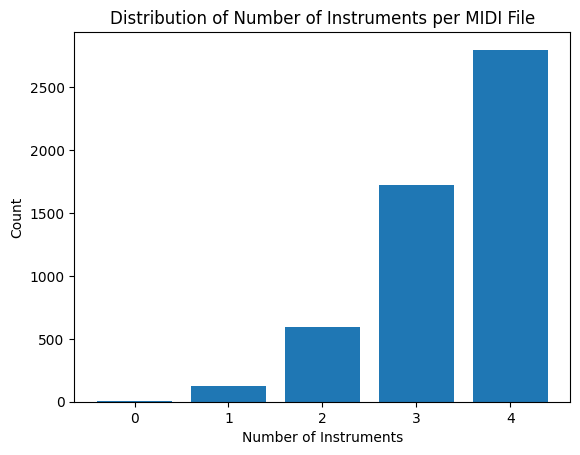

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

x = sorted(num_programs_counts.keys())
y = [num_programs_counts[k] for k in x]

plt.bar(x, y)
plt.title("Distribution of Number of Instruments per MIDI File")
plt.xlabel("Number of Instruments")
plt.ylabel("Count")
plt.xticks(x)  # Show each instrument count as a tick
plt.show()


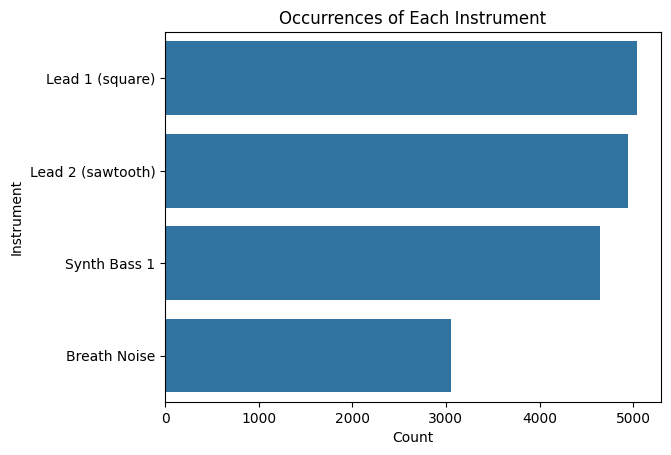

In [26]:

# Optional: Convert to instrument names
from pretty_midi import program_to_instrument_name

program_names = {
    program_to_instrument_name(p): c for p, c in program_counts.items()
}
df_instr = pd.DataFrame(program_names.items(), columns=["Instrument", "Count"]).sort_values("Count", ascending=False)

sns.barplot(data=df_instr, x="Count", y="Instrument")
plt.title("Occurrences of Each Instrument")
plt.xlabel("Count")
plt.ylabel("Instrument")
plt.show()

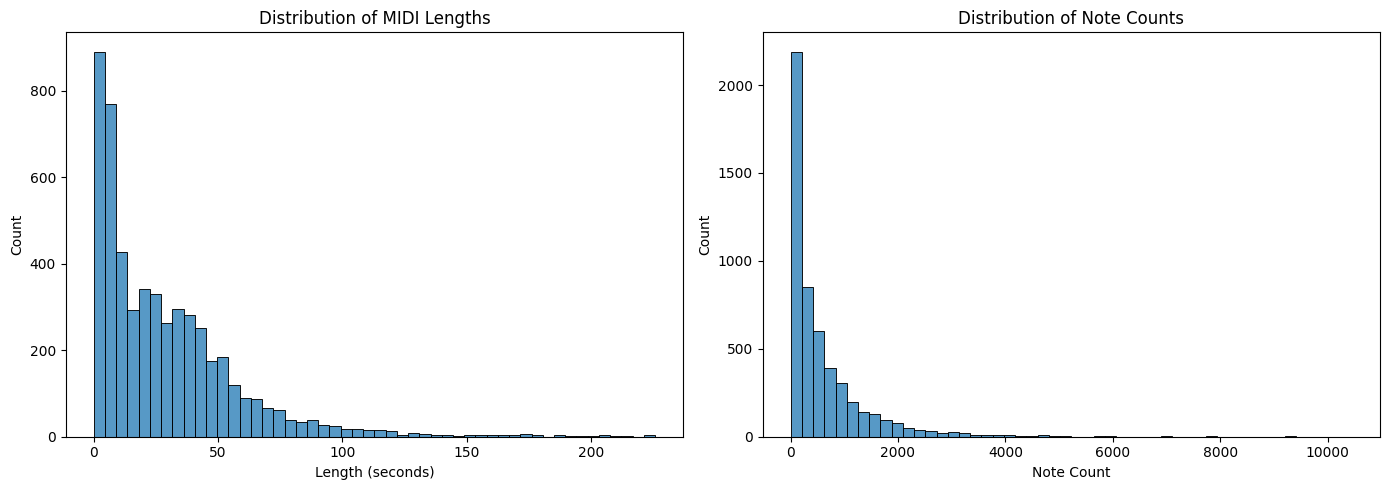

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["length_sec"], bins=50, ax=axs[0])
axs[0].set_title("Distribution of MIDI Lengths")
axs[0].set_xlabel("Length (seconds)")
axs[0].set_ylabel("Count")

sns.histplot(df["note_count"], bins=50, ax=axs[1])
axs[1].set_title("Distribution of Note Counts")
axs[1].set_xlabel("Note Count")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [37]:
df = pd.DataFrame(data)
all_instruments = []
for number_of_instruments, count in num_programs_counts.items():
    all_instruments += [number_of_instruments] * count

MIN_GAME_COUNT = 10
game_names = [extract_game_name(filepath) for filepath in all_filepaths]
game_name_dist = Counter(game_names)
valid_conditional_filepaths = [filepath for filepath in all_filepaths if game_name_dist[extract_game_name(filepath)] >= MIN_GAME_COUNT]
valid_game_names = set([extract_game_name(filepath) for filepath in valid_conditional_filepaths])

summary = {
    "Total MIDI files": len(df),
    "Total number of notes": df["note_count"].sum(),
    "Total length (hours)": round(df["length_sec"].sum()/60/60, 1),
    "Average file duration (sec)": round(df["length_sec"].mean(), 1),
    "MIDI files > 10s": df["over_10_sec"].sum(),
    "MIDI files > 45s": df[df["length_sec"] > 45].shape[0],
    "Unique instruments": len(unique_programs),
    "Average number of instruments per file": round(np.mean(all_instruments), 1),
    "Number of games": len(set(game_names)),
    "Games with at least 10 files": len(set(valid_game_names)),
    }
pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])

,Value
Total MIDI files,5248.0
Total number of notes,3152085.0
Total length (hours),42.5
Average file duration (sec),29.1
MIDI files > 10s,3483.0
MIDI files > 45s,1118.0
Unique instruments,4.0
Average number of instruments per file,3.4
Number of games,394.0
Games with at least 10 files,244.0


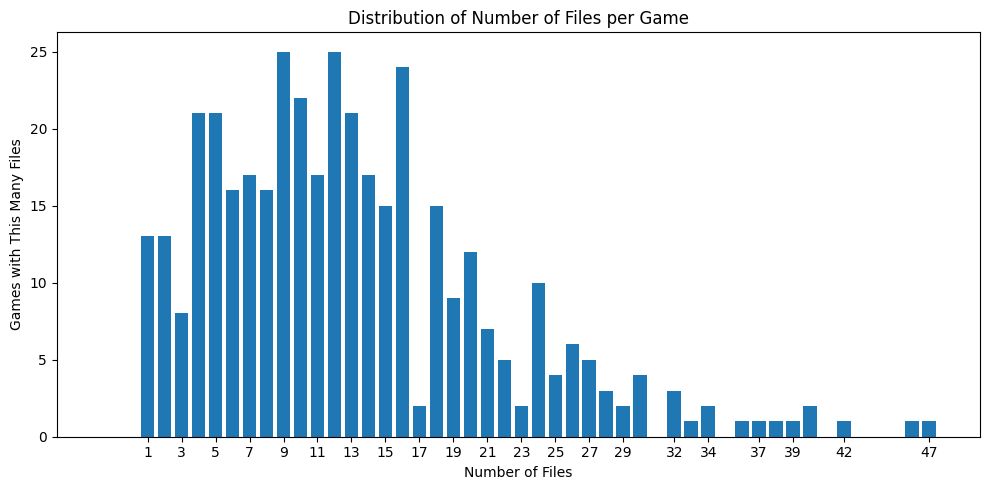

In [56]:
from collections import Counter
import matplotlib.pyplot as plt

game_name_counts_dist = Counter(game_name_dist.values())
x = sorted(game_name_counts_dist.keys())  # x: number of files per game
y = [game_name_counts_dist[k] for k in x]  # y: how many games have that many files

# plt.figure(figsize=(10, 5))
plt.figure(figsize=(10, 5))

plt.bar(x, y)
plt.title("Distribution of Number of Files per Game")
plt.xlabel("Number of Files")
plt.ylabel("Games with This Many Files")
plt.xticks(x[::2])
plt.tight_layout()
plt.xlim(right=50)
plt.show()